In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:

def create_points(nx, ny):
    image_points=[]
    object_points=[]
    object_point = np.zeros((ny*nx,3), np.float32)
    object_point[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
    
    images = glob.glob('calibration_wide/GO*.jpg')
    for i,fname in enumerate(images):
        img = cv2.imread(fname)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_img, (nx,ny),None)
        if ret:
            object_points.append(object_point)
            image_points.append(corners)
    return object_points, image_points


def undistort(img, object_points, image_points):
    img_size=(img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( object_points, image_points, img_size,None,None)
    undistort_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort_image


In [3]:
def binarize_hls(img, channel= 's', thresh=[50,255]):
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel= hls_image[:,:,0]
    l_channel= hls_image[:,:,1]
    s_channel= hls_image[:,:,2]
    
    if channel == 's':
        channel= s_channel
    elif channel == 'h':
        channel= h_channel
    else:
        channel= l_channel
    
    channel_binary= np.zeros_like(channel)
    channel_binary[(channel>thresh[0])&(channel<=thresh[1])]=1
    return channel_binary

In [4]:

def binarize_gradient(img, orientation='x', thresh=[50,255],ksize=[3,3]):
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation =='x':
        sobel = cv2.Sobel(gray_image,cv2.CV_64F,1,0)
    elif orientation == 'y':
        sobel = cv2.Sobel(gray_image,cv2.CV_64F,0,1) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled= np.uint8(255*sobel_abs/np.max(sobel_abs))
    sobel_binary = np.zeros_like(sobel_scaled)
    sobel_binary[(sobel_scaled>thresh[0])&(sobel_scaled<=thresh[1])]=1
    return sobel_binary


In [5]:
def combine_channel_gradient(gradient,channel):
    color_combination = np.dstack((np.zeros_like(gradient),gradient,channel))
    color_binary= np.zeros_like(gradient)
    color_binary[(gradient==1)|(channel==1)]=1
    return color_binary, color_combination

In [6]:
def side2side_plotter(images):
    # Plot the result
    number_of_plots = len(images)
    fig , (ax)= plt.subplots(1, number_of_plots, figsize=(10, 9))
    fig.tight_layout()
    for i in range(number_of_plots):
        ax[i].imshow(images[i][0], cmap='gray')
        ax[i].set_title(images[i][1])
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def single_plotter(image,title):
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()

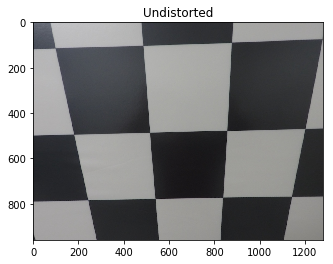

In [7]:
#1 Calibration
# 1-1 undistort
image = mpimg.imread('calibration_wide/test_image.jpg')
object_points, image_points = create_points(8,6)
undistorted_image = undistort(image, object_points, image_points)
single_plotter(undistorted_image, 'Undistorted')


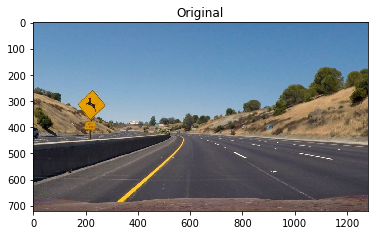

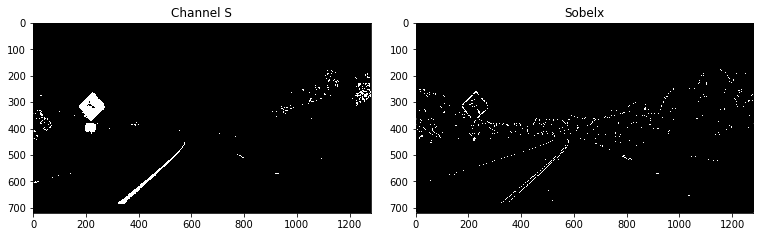

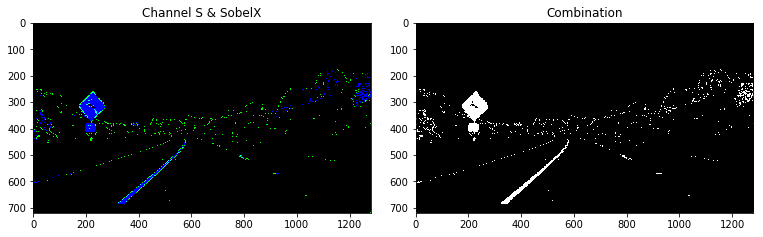

In [8]:
# 3 Color/gradient threshold
image = mpimg.imread('test.jpg')
single_plotter(image, 'Original')
s_channel_binary= binarize_hls(image, channel='s', thresh=[150, 255])
sobelx_binary = binarize_gradient(image, orientation='x',thresh=[50, 100], ksize=[3,3])
color_binary, color_combination = combine_channel_gradient(sobelx_binary, s_channel_binary)


side2side_plotter([(s_channel_binary, 'Channel S'),(sobelx_binary, 'Sobelx')])
side2side_plotter([(color_combination, 'Channel S & SobelX'),(color_binary, 'Combination')])

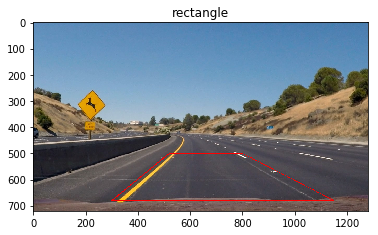

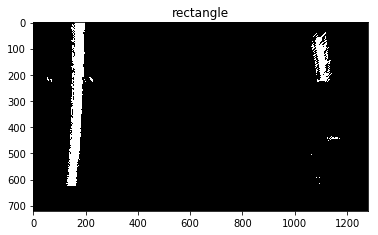

In [9]:
#4 perspective transform
img_copy = np.copy(image)
offset = 100
src_vertices = [[520,500],[800,500],[1150,680],[300,680]]
dst_vertices = [offset,offset],[img_copy.shape[1]-offset,offset],[img_copy.shape[1]-offset,img_copy.shape[0]-offset],[offset,img_copy.shape[0]-offset]
pts = np.array(src_vertices, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=2)
single_plotter(img_copy, 'rectangle')


src =np.float32(src_vertices)
dst=np.float32(dst_vertices)
M = cv2.getPerspectiveTransform(src,dst)
warped_image = cv2.warpPerspective(color_binary, M, (color_binary.shape[1],color_binary.shape[0]))
single_plotter(warped_image, 'rectangle')

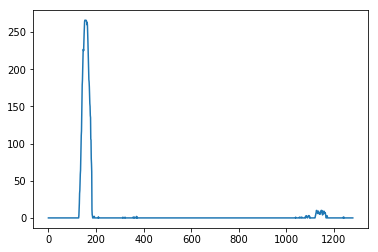

In [10]:
histogram = np.sum(warped_image[int(warped_image.shape[0]/2):,:], axis=0)
plt.plot(histogram)
plt.show()

80
153 1126
-----


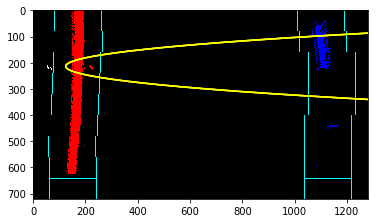

In [13]:
output_img = np.dstack((warped_image, warped_image, warped_image))*255
mid_point = int(histogram.shape[0]/2)
half_left = np.argmax(histogram[:mid_point])
half_right = np.argmax(histogram[mid_point:]) + mid_point

n_windows = 9
left_current = half_left
right_current = half_right

nonzero = warped_image.nonzero()
nonzero_x = np.array(nonzero[1])
nonzero_y = np.array(nonzero[0])

windows_height = int(warped_image.shape[0]/n_windows)
print(windows_height)
print(half_left, half_right)
print("-----")
left_lane=[]
right_lane=[]

margin = 90
min_pixel = 50
for window in range(n_windows):
    y_low = warped_image.shape[0] - (window+1)*windows_height
    y_high= warped_image.shape[0] - (window)*windows_height

    
    x_left_low= left_current-margin
    x_left_high = left_current+margin
    x_right_low= right_current-margin
    x_right_high = right_current+margin
    
    cv2.rectangle(output_img, (x_left_low,y_low),(x_left_high, y_high), (0,255, 255),2)
    cv2.rectangle(output_img, (x_right_low,y_low),(x_right_high, y_high), (0,255, 255),2)
    
    good_left = ((nonzero_y>y_low)&(nonzero_y<y_high)&(nonzero_x>x_left_low)&(nonzero_x<x_left_high)).nonzero()[0]
    good_right = ((nonzero_y>y_low)&(nonzero_y<y_high)&(nonzero_x>x_right_low)&(nonzero_x<x_right_high)).nonzero()[0]
    if good_left.shape[0] >min_pixel:
        left_current = int(np.mean(nonzero_x[good_left]))
    if good_right.shape[0]> min_pixel:
        right_current = int(np.mean(nonzero_x[good_right]))
        
    left_lane.append(good_left)
    right_lane.append(good_right)
    
# single_plotter(output_img, 'windows')

left_lane = np.concatenate(left_lane)
right_lane = np.concatenate(right_lane)

left_x = nonzero_x[left_lane]
right_x= nonzero_x[right_lane]
left_y = nonzero_y[left_lane]
right_y = nonzero_y[right_lane]

left_fit = np.polyfit(left_x, left_y,2)
right_fit = np.polyfit(right_x,right_y,2)

ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
x =np.array(range(0,720))

left_fit_x = left_fit[0]*ploty**2+ left_fit[1]*ploty + left_fit[2]
right_fit_x = right_fit[0]*ploty**2+ right_fit[1]*ploty + right_fit[2]

output_img[left_y, left_x] = [255,0,0]
output_img[right_y, right_x] = [0,0,255]
plt.imshow(output_img)
plt.plot(left_fit_x, ploty, color='yellow')
plt.plot(right_fit_x, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()